#                                             Optimal Price Detection

# Importing Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reading Dataset

In [43]:
data = pd.read_csv('benchmark_data.csv')

In [44]:
data.isna().sum()

Long                0
Lat                 0
Size                0
Light               0
Price_Booking1      0
                   ..
Price_Booking516    0
Price_Booking517    0
Price_Booking518    0
Price_Booking519    0
Price_Booking520    0
Length: 524, dtype: int64

# Data Transform

In [45]:
data.Size.unique()

array(['small', 'large', 'medium'], dtype=object)

In [46]:
data['Size'] = data['Size'].map({'small': 1, 'medium': 2, 'large': 3})

In [47]:
week_num = 520
df = pd.DataFrame()
for i in range(0, 2000):
  df_temp = {
    'Date': np.arange(1, week_num + 1),
    'Long': [data['Long'][i]] * week_num,
    'Lat': [data['Lat'][i]] * week_num,
    'Size': [data['Size'][i]] * week_num,
    'Light': [data['Light'][i]] * week_num,
    'Price': data.iloc[i, 4:].apply(lambda x: eval(x)[0]),
    'Ratio': data.iloc[i, 4:].apply(lambda x: eval(x)[1])
    }

  # Append in DataFrame
  df_temp = pd.DataFrame(df_temp)
  df = pd.concat([df, df_temp], ignore_index=True)
df.sample()

,Date,Long,Lat,Size,Light,Price,Ratio
740950,471,-33,4,2,1,52.224344,0.1655


<Axes: >

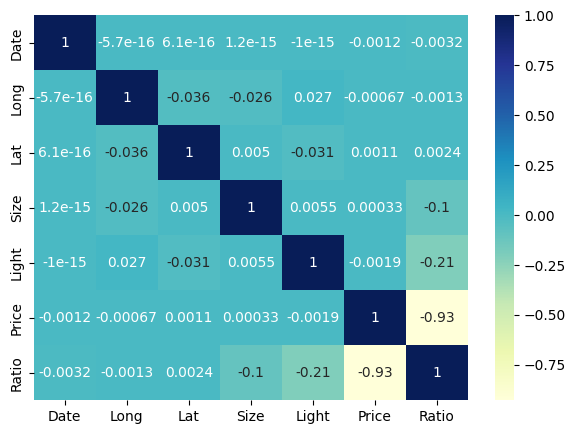

In [9]:
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

# Training model

In [31]:
# Split the data into features and labels
features = df[['Date', 'Long', 'Lat', 'Size', 'Light', 'Price']]
labels = df['Ratio']

# Split the data into training and validation
features_train, features_validation, labels_train, labels_validation = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=features_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(features_train, labels_train, validation_data=(features_validation, labels_validation), epochs=60, batch_size=128)


Epoch 1/60
6500/6500 [==============================] - 14s 2ms/step - loss: 0.2944 - val_loss: 0.0100
Epoch 2/60
6500/6500 [==============================] - 15s 2ms/step - loss: 0.0141 - val_loss: 0.0065
Epoch 3/60
6500/6500 [==============================] - 14s 2ms/step - loss: 0.0118 - val_loss: 0.0064
Epoch 4/60
6500/6500 [==============================] - 15s 2ms/step - loss: 0.0091 - val_loss: 0.0042
Epoch 5/60
6500/6500 [==============================] - 14s 2ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 6/60
6500/6500 [==============================] - 13s 2ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 7/60
6500/6500 [==============================] - 14s 2ms/step - loss: 0.0046 - val_loss: 0.0110
Epoch 8/60
6500/6500 [==============================] - 14s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 9/60
6500/6500 [==============================] - 15s 2ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/60
6500/6500 [==============================] - 14s 2ms/step - l

# Find optimal prices for each billboard

In [ ]:
# Define a range of possible prices
opt_price = []
range_of_prices = 800

for i in range(0, 2000):
  longitude = df['Long'][week_num * i]
  latitude = df['Lat'][week_num  * i]
  size = df['Size'][week_num  * i]
  light = df['Light'][week_num  * i]

  prices = df['Price'][(i) * week_num : week_num * (i + 1)]
  min_price = min(prices)
  max_price = max(prices)
  prices = np.linspace(min_price, max_price, num=range_of_prices)

  features = {
      'Date': [week_num + 1] * range_of_prices,
      'Long': [longitude] * range_of_prices,
      'Lat': [latitude] * range_of_prices,
      'Size': [size] * range_of_prices,
      'Light': [light] * range_of_prices,
      'Price': prices
  }
  features = pd.DataFrame(features)

  # Predict the booking ratios
  booking_ratios = model.predict(features)
  booking_ratios = booking_ratios.reshape(-1)

  # Calculate the expected revenues
  revenues = prices * booking_ratios * 7

  # Find the price that gives the highest expected revenue
  opt_price.append(prices[np.argmax(revenues)])

# Save in Output_Bachmark.csv

In [41]:
# Convert the list to a DataFrame
output_df = pd.DataFrame(opt_price, columns=['Optimal_Price'])

# Save the DataFrame to a CSV file
output_df.to_csv('output_benchmark_data.csv', index=False)
